<h1>Submission for SkillCorner X PySport Analytics Cup

<h2>Decision - xT metric

<h4>Author: Anar Abiyev

<h1>Intrduction

Expected Threat (xT) has become a standard metric for evaluating on-ball actions in football by quantifying how much each action increases the probability of scoring. While xT effectively captures the *outcome value* of actions, it does not explicitly account for the *decision quality* underlying those actions. As a result, players may be rewarded equally for identical xT outcomes despite facing very different sets of available alternatives at the moment of decision.

This notebook introduces **Decision-xT (D-xT)**, a context-aware extension of the xT framework that incorporates decision quality into passing evaluation. Using SkillCorner's passing options data, D-xT evaluates each passing action relative to all available alternatives within the same possession. By comparing the executed pass to the optimal option under contextual constraints such as pressure, field position, player role, and match state, the method penalizes xT values that arise from suboptimal decision-making.

The goal of this approach is not to replace xT, but to complement it with a decision-sensitive adjustment that better reflects the quality of player choices. Through match- and player-level analyses, this notebook demonstrates how D-xT systematically down-weights inefficient decisions while preserving value generated through consistently optimal pass selection.


In [ ]:
#!pip install mplsoccer

In [32]:
from mplsoccer import Pitch

import numpy as np
import glob
import os
import matplotlib.pyplot as plt

import json
import requests

import pandas as pd
pd.set_option("display.max_columns", None)

import numpy as np
import json

match_ids = ["1886347","1899585","1925299","1953632","1996435","2006229","2011166","2013725","2015213","2017461"]

<h1>Methodology

The functions below are the core functions to calculate the introduced metric.

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

The function below is utilized to add a flag column for each on-ball possesion to identify the choice of the player among passing options.

In [3]:
def add_passing_choice_flag(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create column 'passing_choice' to flag the chosen passing option.
    """
    df = df.copy()

    is_option = df["event_type"].eq("passing_option")

    chosen_ids = set(
        df["targeted_passing_option_event_id"]
        .dropna()
        .astype(df["event_id"].dtype)
    )

    df["passing_choice"] = np.nan
    df.loc[is_option, "passing_choice"] = (df.loc[is_option, "event_id"].isin(chosen_ids))

    return df


<h2> Contextual Risk Aversion ($\lambda$)

To account for how decision-making risk varies across game contexts, a contextual risk-aversion parameter, $\lambda$, is computed for each possession. This parameter controls how strongly the expected cost of a turnover is weighted when evaluating passing options.

The value of $\lambda$ is bounded to the interval $[\lambda_{\min}, \lambda_{\max}]$ and is defined as a sigmoid transformation of a linear combination of contextual features:

- **Player role**: Players are grouped into four positional categories (defenders, wingbacks/defensive midfielders, midfielders, and forwards), with deeper roles assigned higher baseline risk aversion.
- **Pitch zone**: Possessions starting in the defensive third receive higher risk aversion than those in more advanced areas.
- **Defensive pressure**: A composite pressure index is constructed from player-opponent separation, a close-pressure indicator, and pressing chain length, capturing both proximity and intensity of pressure.
- **Match urgency**: An urgency index increases when a team is losing and later in the match, reducing risk aversion in situations where higher-risk actions may be justified.

A latent score $z$ is computed as a weighted sum of these components, and $\lambda$ is obtained via a bounded sigmoid mapping. This formulation ensures that risk aversion adapts smoothly to tactical, spatial, and temporal context, reflecting that the cost of losing possession is not constant across situations.


In [4]:
def compute_risk_lambda(
    df: pd.DataFrame,
    *,
    # λ range
    lambda_min: float = 0.3,
    lambda_max: float = 2.0,
    # linear weights for the sigmoid input
    beta0: float = 0.0,
    beta_role: float = 0.8,
    beta_zone: float = 0.9,
    beta_pressure: float = 1.0,
    beta_urgency: float = 1.2,
    # urgency weights
    u0: float = 0.0,
    u_score: float = 1.0,
    u_time: float = 1.0,
    # pressure construction
    sep_ref: float = 10.0,         # ~ separation where pressure is "mid"
    sep_scale: float = 4.0,        # larger -> smoother; smaller -> steeper
    chain_scale: float = 4.0,      # pressing_chain_length scaling
    w_sep: float = 0.6,
    w_close: float = 0.25,
    w_chain: float = 0.15,
    out_col: str = "risk_lambda",
):
    """
    Computes risk aversion λ_e in [lambda_min, lambda_max] per row.
    """

    df = df.copy()

    # --- 1) Role group mapping (4 groups as requested) ---
    g1 = {"GK", "LB", "LCB", "CB", "RCB", "RB"}
    g2 = {"LWB", "LDM", "DM", "RDM", "RWB"}
    g3 = {"LM", "CM", "RM", "AM"}
    g4 = {"LW", "RW", "LF", "CF", "RF"}

    # Higher => more conservative by default
    role_group_score = {
        1: 1.00,  # GK/Back line
        2: 0.70,  # Wingbacks/DMs
        3: 0.45,  # Mids/AM
        4: 0.20,  # Forwards
    }

    pos = df["player_in_possession_position"].astype("string")
    df["_role_group"] = np.select(
        [pos.isin(g1), pos.isin(g2), pos.isin(g3), pos.isin(g4)],
        [1, 2, 3, 4],
        default=np.nan,
    ).astype("float")

    df["_role"] = df["_role_group"].map(role_group_score).astype("float")

    # --- 2) Zone (third) mapping ---
    third_map = {
        "defensive_third": 1.00,
        "middle_third": 0.55,
        "attacking_third": 0.20,
    }
    df["_zone"] = df["player_in_possession_third_start"].map(third_map).astype("float")

    # --- 3) Pressure index in [0,1] ---
    # separation_start: smaller -> higher pressure
    sep = pd.to_numeric(df["separation_start"], errors="coerce")
    # pressure_from_sep: ~1 when sep << sep_ref, ~0 when sep >> sep_ref
    pressure_from_sep = sigmoid((sep_ref - sep) / sep_scale)

    close = df["close_at_player_possession_start"].astype("float").fillna(0.0)  # bool -> 0/1
    chain = pd.to_numeric(df["pressing_chain_length"], errors="coerce").fillna(0.0)
    pressure_from_chain = 1 - np.exp(-chain / chain_scale)  # saturating 0..~1

    df["_pressure"] = (
        w_sep * pressure_from_sep
        + w_close * close.clip(0, 1)
        + w_chain * pressure_from_chain.clip(0, 1)
    ).clip(0, 1)

    # --- 4) Urgency index in [0,1] (higher when losing late) ---
    score_diff = pd.to_numeric(df["team_score"], errors="coerce") - pd.to_numeric(df["opponent_team_score"], errors="coerce")
    time_frac = pd.to_numeric(df["minute_start"], errors="coerce") / 90.0
    time_frac = time_frac.clip(0, 1)

    # Losing (negative score_diff) increases urgency; later time increases urgency
    df["_urgency"] = sigmoid(u0 - u_score * score_diff + u_time * time_frac)

    # new
    df["_urgency"] = df["_urgency"] - 0.5

    # --- 5) λ calculation ---
    z = (
        beta0
        + beta_role * df["_role"]
        + beta_zone * df["_zone"]
        + beta_pressure * df["_pressure"]
        - beta_urgency * df["_urgency"]
    )
    df[out_col] = lambda_min + (lambda_max - lambda_min) * sigmoid(z)

    # (Optional) drop temp cols
    #df.drop(columns=["_role_group", "_role", "_zone", "_pressure", "_urgency"], inplace=True)

    return df

<h2> Attacking Expected Value (AttackEV)

For each passing option, an attacking expected value, denoted as $\text{AttackEV}$, is computed to quantify the potential offensive benefit of a completed pass. AttackEV is defined as the product of the probability that the pass is successfully completed and the resulting xThreat (xT) gain if the pass is completed:

\$
\text{AttackEV} = p_{\text{comp}} \cdot \Delta xT
\$

Pass completion probability is taken from the expected pass completion model when available, with a fallback to the realized pass completion probability for the targeted pass if necessary. Similarly, xThreat values are taken from the passing-option xT estimates, with a fallback to the realized xT of the executed pass when option-level estimates are unavailable.

AttackEV is computed only for rows corresponding to passing options, and remains undefined for other event types. This formulation captures the expected attacking contribution of each available passing option, independent of turnover risk or decision context.


In [5]:
def compute_attack_ev(
    df: pd.DataFrame,
    *,
    out_col: str = "attack_ev",
    xthreat_col: str = "xthreat",
    xpass_col: str = "xpass_completion",
    fallback_xthreat_col: str = "player_targeted_xthreat",
    fallback_xpass_col: str = "player_targeted_xpass_completion",
):
    """
    AttackEV = p(pass completes) * xT gain if completed.
    """
    df = df.copy()
    is_opt = df["event_type"].eq("passing_option")

    # Start with all-NaN; fill only for passing options
    df[out_col] = np.nan

    xT = df[xthreat_col].where(df[xthreat_col].notna(), df[fallback_xthreat_col])
    p  = df[xpass_col].where(df[xpass_col].notna(), df[fallback_xpass_col])

    df.loc[is_opt, out_col] = (p * xT).loc[is_opt]

    return df

<h2> Turnover Expected Value (TurnoverEV)

To account for the downside of losing possession, a turnover expected value, $\text{TurnoverEV}$, is computed for each *passing option*. This term represents the expected turnover cost as the product of pass failure probability and a contextual risk multiplier:

\$
\text{TurnoverEV}_i = q_i \cdot m_i
\qquad\text{where}\qquad
q_i = 1 - p_i
\$

Here, $p_i$ is the predicted pass completion probability (`xpass_completion`). To avoid unstable extremes, $p_i$ is clamped to $[p_{\varepsilon}, 1-p_{\varepsilon}]$ before computing $q_i$.

The risk multiplier $m_i$ captures how costly a failed pass is likely to be, based on three option-level factors:

1. **Pass difficulty** ($D_i$): a binary indicator (`difficult_pass_target`).
2. **Pass distance** ($\widetilde{d}_i$): pass distance normalized *within the same possession's option set* (min-max scaled to $[0,1]$).
3. **Receiver pressure** ($\widetilde{\pi}_i$): opponents within 5m of the target, capped and scaled to $[0,1]$.

$
m_i = \operatorname{clip}\Big(
1 + w_{\text{diff}}D_i + w_{\text{dist}}\widetilde{d}_i + w_{\text{press}}\widetilde{\pi}_i,\; m_{\min},\; m_{\max}
\Big)
$

Finally, TurnoverEV is computed only for rows corresponding to passing options (`event_type == "passing_option"`), and remains undefined for other event types.


In [6]:
def compute_turnover_ev_passing_options(
    df: pd.DataFrame,
    *,
    possession_link_col: str = "associated_player_possession_event_id",

    # risk-multiplier weights
    w_difficult: float = 0.15,
    w_distance: float = 0.20,
    w_receiver_pressure: float = 0.30,

    # caps
    m_min: float = 1.0,
    m_max: float = 2.5,

    # receiver pressure scaling
    receiver_pressure_cap: float = 4.0,

    # probability clamp
    p_eps: float = 0.01,
) -> pd.DataFrame:
    """
    Compute TurnoverEV ONLY for event_type == 'passing_option'.
    """

    out = df.copy()
    opt_mask = out["event_type"].astype(str).eq("passing_option")

    # 1) Failure probability q_i

    p = pd.to_numeric(out.loc[opt_mask, "xpass_completion"], errors="coerce")
    p = p.clip(p_eps, 1.0 - p_eps)
    q = 1.0 - p

    out.loc[opt_mask, "p_complete"] = p
    out.loc[opt_mask, "q_fail"] = q

    # 2) Risk multiplier m_i

    # pass difficulty (binary)
    difficult = (
        out.loc[opt_mask, "difficult_pass_target"]
        .fillna(False)
        .astype(bool)
        .astype(int)
    )

    dist = pd.to_numeric(out.loc[opt_mask, "pass_distance"], errors="coerce")

    def normalize_within_group(x: pd.Series) -> pd.Series:
        xmin = x.min(skipna=True)
        xmax = x.max(skipna=True)
        if pd.isna(xmin) or pd.isna(xmax) or xmax <= xmin:
            return pd.Series(0.0, index=x.index)
        return ((x - xmin) / (xmax - xmin)).clip(0.0, 1.0).fillna(0.0)

    dist_norm = (
        dist
        .groupby(out.loc[opt_mask, possession_link_col])
        .transform(normalize_within_group)
    )

    opp5 = pd.to_numeric(
        out.loc[opt_mask, "n_player_targeted_opponents_within_5m_start"],
        errors="coerce",
    ).fillna(0.0)

    pressure_norm = opp5.clip(0.0, receiver_pressure_cap) / receiver_pressure_cap

    m = (
        1.0
        + w_difficult * difficult
        + w_distance * dist_norm
        + w_receiver_pressure * pressure_norm
    ).clip(m_min, m_max)

    out.loc[opt_mask, "risk_multiplier_mi"] = m

    # 3) TurnoverEV
    out.loc[opt_mask, "turnoverEV"] = (
        out.loc[opt_mask, "q_fail"]
        * out.loc[opt_mask, "risk_multiplier_mi"]
    )

    return out

<h2> Decision Penalty and Penalized xT

To translate decision quality into an xT adjustment, a possession-level penalty factor is computed from the set of available passing options. For each possession $p$, the utility values $U_{p,i}$ of all passing options are aggregated to obtain the best, worst, and chosen utilities:


$
U^{best}_p = \max_i U_{p,i}, \quad
U^{worst}_p = \min_i U_{p,i}, \quad
U^{chosen}_p = U_{p,i^\*}.
$


Decision suboptimality is measured via regret, normalized by the within-possession utility spread:

$
S_p = \max\!\left(U^{best}_p - U^{worst}_p,\; s_0\right), \qquad
r_p = \operatorname{clip}\!\left(\frac{U^{best}_p - U^{chosen}_p}{S_p},\, 0,\, 1\right),
$

where $s_0$ is a small spread floor (set to $0.002$) for numerical stability.

Normalized regret is then mapped to a bounded penalty factor using an anchored logistic function:

$
\text{raw}(r_p) = \frac{1}{1+\exp\!\left(k(r_p-c)\right)}, \qquad
f_p = \operatorname{clip}\!\left(\frac{\text{raw}(r_p)}{\text{raw}(0)},\, \varepsilon,\, 1\right),
$

with parameters $k$ (steepness) and $c$ (midpoint). Anchoring ensures $f_p = 1$ when $r_p = 0$, i.e., when the best option is chosen.

Finally, the penalized xThreat for the targeted pass is computed on `player_possession` rows as:

\$
xT^{pen}_p = xT^{actual}_p \cdot f_p.
\$

The resulting columns are `passing_penalty_factor` and `player_targeted_xthreat_penalized`, while non-possession rows remain undefined.


In [7]:
def apply_fair_passing_penalty(
    df: pd.DataFrame,
    *,
    possession_id_col: str = "event_id",
    option_possession_link_col: str = "associated_player_possession_event_id",
    option_u_col: str = "pass_U",
    choice_col: str = "passing_choice",
    event_type_col: str = "event_type",
    xthreat_actual_col: str = "player_targeted_xthreat",


    k: float = 8.0,
    c: float = 0.4,

    eps: float = 1e-9,
    out_factor_col: str = "passing_penalty_factor",
    out_xthreat_col: str = "player_targeted_xthreat_penalized",
) -> pd.DataFrame:
    """
    Creates:
      - passing_penalty_factor: factor in (0,1] on player_possession rows (NaN elsewhere)
      - player_targeted_xthreat_penalized: xThreat after penalty (NaN elsewhere)
    """
    out = df.copy()

    is_option = out[event_type_col].astype(str).eq("passing_option")
    is_poss  = out[event_type_col].astype(str).eq("player_possession")

    # --- 1) Build per-possession summary from passing_option rows ---
    opt = out.loc[is_option, [option_possession_link_col, option_u_col, choice_col]].copy()

    # Ensure numeric U
    opt[option_u_col] = pd.to_numeric(opt[option_u_col], errors="coerce")

    # Best and worst option utilities per possession
    grp = opt.groupby(option_possession_link_col, dropna=False)[option_u_col]
    best_u = grp.max()
    worst_u = grp.min()

    # Chosen utility per possession (where passing_choice == True)
    # Using max() protects against duplicate chosen flags within a possession.
    chosen_u = (
        opt.loc[opt[choice_col] == True]
        .groupby(option_possession_link_col, dropna=False)[option_u_col]
        .max()
    )

    summary = pd.DataFrame({
        "best_u": best_u,
        "worst_u": worst_u,
        "chosen_u": chosen_u
    })

    # --- 2) Compute normalized regret and anchored logistic factor ---
    #spread = (summary["best_u"] - summary["worst_u"]).clip(lower=0.01) #eps
    SPREAD_FLOOR = 0.002   # ≈ median spread from your stats
    spread = (best_u - worst_u).clip(lower=SPREAD_FLOOR)


    regret = (summary["best_u"] - summary["chosen_u"])

    # If no chosen_u exists, norm_regret stays NaN -> factor stays NaN
    norm_regret = regret / spread

    # Keep within [0, 1] for stable behavior (handles noisy utilities)
    norm_regret = norm_regret.clip(lower=0.0, upper=1.0)

    # Anchored logistic: ensures factor == 1 when norm_regret == 0
    raw = 1.0 / (1.0 + np.exp(k * (norm_regret - c)))
    raw0 = 1.0 / (1.0 + np.exp(-k * c))  # raw at 0
    factor = raw / raw0

    # Numerical safety: keep in (0, 1]
    factor = factor.clip(lower=eps, upper=1.0)

    summary[out_factor_col] = factor

    # --- 3) Attach factor to player_possession rows via possession id ---
    out[out_factor_col] = np.nan
    out.loc[is_poss, out_factor_col] = (
        out.loc[is_poss, possession_id_col].map(summary[out_factor_col])
    )

    # --- 4) Apply penalty to actual xThreat on possession rows ---
    out[out_xthreat_col] = np.nan
    out.loc[is_poss, out_xthreat_col] = (
        pd.to_numeric(out.loc[is_poss, xthreat_actual_col], errors="coerce")
        * out.loc[is_poss, out_factor_col]
    )

    return out

<h4>Columns to be used

In [8]:
pass_cols = [
    # 2.1 Identifiers & linking
    "match_id", "event_id", "event_type",'frame_start', 'frame_end',
'frame_physical_start', "n_passing_options","player_id", "team_id",
    "associated_player_possession_end_type",
    "associated_player_possession_event_id",
    "targeted_passing_option_event_id",
    "predicted_passing_option",
    "passing_option_at_pass_moment",
    "passing_option_at_player_possession_start",

    # 2.2 Player & role
    "player_in_possession_id",
    "player_in_possession_position", "player_in_possession_position_id",
    "player_position", "player_position_id",

    # 2.3 Game & score context
    "period", "minute_start", "second_start",
    "team_score", "opponent_team_score",
    "game_state",

    # 2.4 Field location & zone
    "player_in_possession_x_start", "player_in_possession_y_start",
    "player_in_possession_third_start", "player_in_possession_channel_start",
    "player_in_possession_penalty_area_start",
    "player_targeted_x_pass", "player_targeted_y_pass",
    "player_targeted_third_pass", "player_targeted_channel_pass",
    "player_targeted_penalty_area_pass",
    "x_start", "y_start",

    # 2.5 xT & pass difficulty
    "player_targeted_xthreat", "player_targeted_xpass_completion",
    "pass_outcome", "pass_outcome_id",
    "xthreat", "xpass_completion",
    "passing_option_score",

    # 2.6 Risk, pressure & defensive context
    "separation_start", "separation_end", "separation_gain",
    "interplayer_distance_start", "interplayer_distance_min",
    "close_at_player_possession_start",
    "organised_defense", "defensive_structure", "n_defensive_lines",
    "pressing_chain", "pressing_chain_length", "pressing_chain_end_type",
    "possession_danger",
    "n_player_targeted_opponents_within_5m_start",
    "n_player_targeted_opponents_within_5m_end",
    "n_player_targeted_opponents_ahead_start",
    "n_opponents_ahead_player_in_possession_pass_moment",
    "inside_defensive_shape_start",

    # 2.7 Pass style / progression / line-break
    "pass_distance", "pass_range", "pass_angle", "pass_direction", "pass_ahead",
    "first_line_break", "second_last_line_break", "last_line_break",
    "furthest_line_break",
    "n_opponents_bypassed",
    "dangerous", "player_targeted_dangerous",
    "difficult_pass_target", "player_targeted_difficult_pass_target",
    "n_passing_options_line_break", "n_passing_options_last_line_break",

    # 2.8 Don't-punish-backpasses context
    "xloss_player_possession_start",
    "xloss_player_possession_end",
    "xloss_player_possession_max",
    "force_backward",
    "reduce_possession_danger",
    "stop_possession_danger"
]

<h2> Match Processing Loop (Data Loading, D-xT Computation, and Export)

For each match in `match_ids`, the corresponding `dynamic_events.csv` file is loaded directly from the SkillCorner Open Data GitHub repository using a raw URL. The event stream is then filtered to retain only `player_possession` and `passing_option` rows, which contain the executed action and its available passing alternatives.

Passing-related columns are selected and possessions with zero available options are removed. Next, the contextual risk-aversion term (`risk_lambda`), attacking expected value (`attack_ev`), and turnover expected value (`turnoverEV`) are computed for passing options. The executed pass is identified via a choice flag, enabling comparison between the chosen option and the best available alternative.

Option utility is computed as

\$
U = \text{attack\_ev} - \lambda \cdot \alpha \cdot \text{turnoverEV},
\$

with a fixed scaling parameter $\alpha=0.017$. A decision penalty factor is then derived from normalized regret and applied to the realized xThreat on `player_possession` rows, producing penalized xT.


The scaling parameter $\alpha$ controls the relative weight of turnover risk in the passing-option utility function. It was calibrated by matching the mean attacking expected value to the mean unscaled risk term, defined as the product of contextual risk aversion and turnover expected value. This yields balanced scaling between attack and risk components. Based on this calibration, a fixed value of $\alpha = 0.017$ was applied across all matches.


Finally, match-level results are aggregated to player totals (`xthreat_sum` and `xthreat_penalized_sum`) and exported as one CSV per match in the `results/` directory.


In [23]:
BASE_URL = "https://raw.githubusercontent.com/SkillCorner/opendata/master/data/matches"

for match_id in match_ids:
  url = f"{BASE_URL}/{match_id}/{match_id}_dynamic_events.csv"
  df_events = pd.read_csv(url)

  df_events_passing = df_events[
    df_events['event_type'].isin(['player_possession', 'passing_option'])
  ]

  df_passing = df_events_passing[pass_cols]
  df_passing = df_passing[df_passing['n_passing_options'] != 0]

  df_passing = compute_risk_lambda(df_passing, out_col="risk_lambda")

  df_passing = compute_attack_ev(
      df_passing,
      out_col="attack_ev"
  )

  df_passing = compute_turnover_ev_passing_options(df_passing)
  df_passing = add_passing_choice_flag(df_passing)

  ALPHA = 0.017
  df_passing["pass_U"] = (
      df_passing["attack_ev"]
      - df_passing["risk_lambda"] * ALPHA * df_passing["turnoverEV"]
  )

  df_passing = apply_fair_passing_penalty(
    df_passing,
    possession_id_col="event_id",
    option_possession_link_col="associated_player_possession_event_id",
    option_u_col="pass_U",
    choice_col="passing_choice",
    event_type_col="event_type",
    xthreat_actual_col="player_targeted_xthreat",
    k=3.0,
    c=0.7,
  )

  df_passing.to_csv("results/" + match_id + "_df_passing.csv", index=False)

  result = (
    df_passing
    .groupby("player_id", as_index=False)
    .agg(
        xthreat_sum=("player_targeted_xthreat", "sum"),
        xthreat_penalized_sum=("player_targeted_xthreat_penalized", "sum"),
    )
  )

  result.to_csv("results/" + match_id + "_results.csv", index=False)



/tmp/ipython-input-3254443728.py:42: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna(False)
/tmp/ipython-input-1473310422.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[False  True False ... False  True False]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[is_option, "passing_choice"] = (df.loc[is_option, "event_id"].isin(chosen_ids))
/tmp/ipython-input-1089370853.py:5: DtypeWarning: Columns (276) have mixed types. Specify dtype option on import or set low_memory=False.
  df_events = pd.read_csv(url)
/tmp/ipython-input-3254443728.py:42: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated a

<h1>Results and Discussion

In [17]:
def load_all_match_results(results_dir="results"):
    files = sorted(glob.glob(os.path.join(results_dir, "*_results.csv")))
    if len(files) == 0:
        raise FileNotFoundError(f"No *_results.csv files found in {results_dir}/")

    all_df = []
    for f in files:
        match_id = os.path.basename(f).split("_")[0]
        df = pd.read_csv(f)

        # clean common artifact column
        if "Unnamed: 0" in df.columns:
            df = df.drop(columns=["Unnamed: 0"])

        df["match_id"] = match_id
        all_df.append(df)

    out = pd.concat(all_df, ignore_index=True)

    # helpful derived columns
    out["abs_reduction"] = out["xthreat_sum"] - out["xthreat_penalized_sum"]
    out["rel_reduction"] = np.where(
        out["xthreat_sum"] > 0,
        out["abs_reduction"] / out["xthreat_sum"],
        np.nan
    )
    return out

all_results = load_all_match_results("results")
all_results.head()


,player_id,xthreat_sum,xthreat_penalized_sum,match_id,abs_reduction,rel_reduction
0,14736,0.1952,0.161112,1886347,0.034088,0.174631
1,23418,0.5859,0.432129,1886347,0.153771,0.262453
2,31147,0.0003,0.000298,1886347,0.000002,0.006467
3,33697,0.1220,0.088232,1886347,0.033768,0.276785
4,38673,0.5557,0.335465,1886347,0.220235,0.396320


**Figure 1. Match-level comparison of total xT and Decision-xT (D-xT).**  
The figure below shows total xT (blue) and decision-adjusted xT (orange) for each match. Across all matches, D-xT is consistently lower than raw xT, with reductions ranging from approximately 19% to 30%. This systematic decrease reflects the penalization of xT generated through suboptimal passing decisions, while preserving value in matches where players more frequently selected near-optimal options.


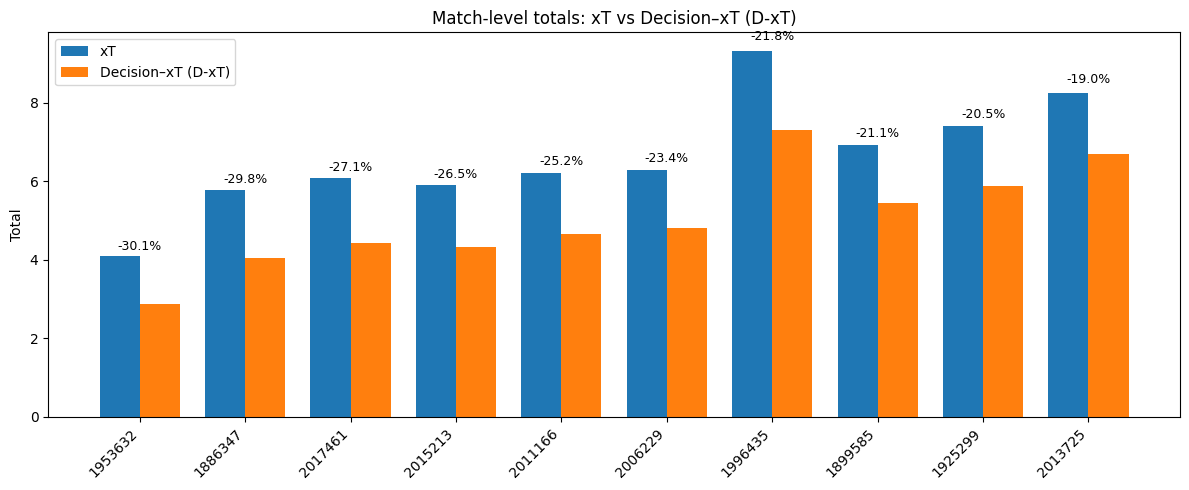

In [18]:
match_summary = (
    all_results.groupby("match_id", as_index=False)
    .agg(xT=("xthreat_sum", "sum"), DxT=("xthreat_penalized_sum", "sum"))
)
match_summary["pct_drop"] = (match_summary["xT"] - match_summary["DxT"]) / match_summary["xT"]

match_summary = match_summary.sort_values("pct_drop", ascending=False)

x = np.arange(len(match_summary))
width = 0.38

plt.figure(figsize=(12, 5))
plt.bar(x - width/2, match_summary["xT"], width, label="xT")
plt.bar(x + width/2, match_summary["DxT"], width, label="Decision–xT (D-xT)")
plt.xticks(x, match_summary["match_id"], rotation=45, ha="right")
plt.ylabel("Total")
plt.title("Match-level totals: xT vs Decision–xT (D-xT)")
plt.legend()

# annotate % drop above bars
for i, pct in enumerate(match_summary["pct_drop"]):
    plt.text(i, max(match_summary.loc[match_summary.index[i], ["xT","DxT"]]) * 1.02,
             f"-{pct*100:.1f}%", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()


Across all matches, total xT decreases from 66.28 to 50.49 after applying the decision-based penalty, corresponding to an absolute reduction of 15.78 xT (23.8%). This indicates that nearly one quarter of the aggregate xT in the dataset is attributable to passes that were suboptimal relative to the available alternatives at the time of decision.


In [19]:
total_xT = all_results["xthreat_sum"].sum()
total_DxT = all_results["xthreat_penalized_sum"].sum()
pct_drop = (total_xT - total_DxT) / total_xT

pd.DataFrame([{
    "Total xT": total_xT,
    "Total D-xT": total_DxT,
    "Absolute drop": total_xT - total_DxT,
    "% drop": pct_drop
}])


,Total xT,Total D-xT,Absolute drop,% drop
0,66.2752,50.494485,15.780715,0.238109


The pie chart illustrates the proportion of total xT retained and removed by the decision-based adjustment. Approximately 76.2% of xT is preserved as Decision-xT (D-xT), while 23.8% is penalized away, reflecting the share of xT generated through comparatively inefficient passing decisions.


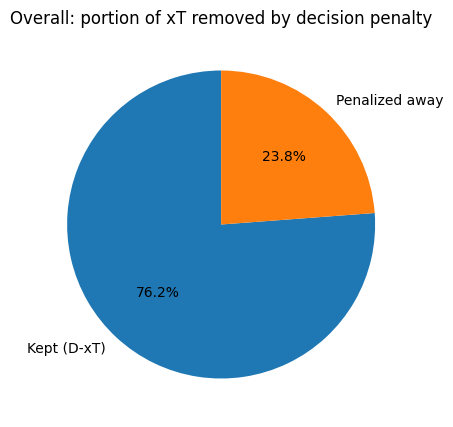

In [20]:
plt.figure(figsize=(5,5))
plt.pie([total_DxT, total_xT-total_DxT], labels=["Kept (D-xT)", "Penalized away"], autopct="%.1f%%", startangle=90)
plt.title("Overall: portion of xT removed by decision penalty")
plt.show()


**Figure 2. Player-level comparison of xT and Decision-xT (D-xT).**  
Each point represents a player's total xT and corresponding Decision-xT aggregated across matches. The diagonal line indicates equality between xT and D-xT. Most observations lie below the diagonal, showing that decision penalties systematically reduce xT. The dispersion below the line highlights substantial heterogeneity in decision quality: some players preserve most of their xT, while others experience large reductions, despite similar raw xT values.


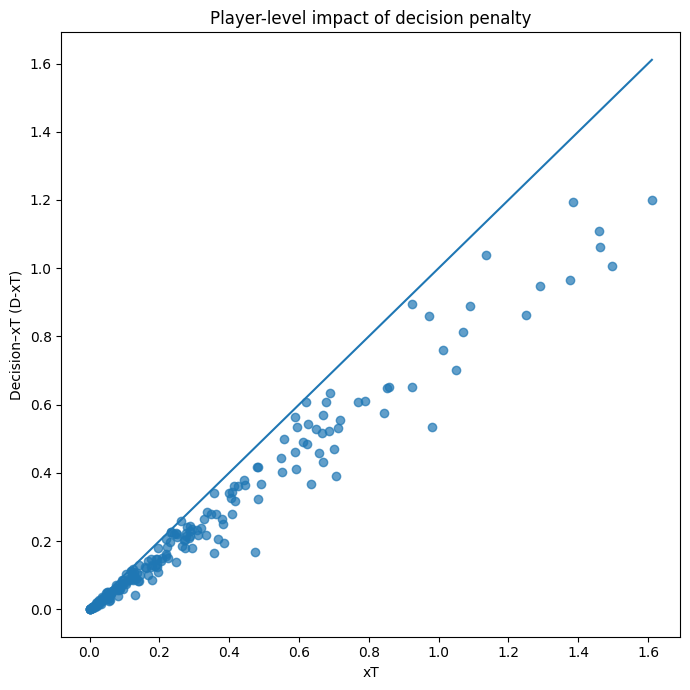

In [21]:
player_summary = (
    all_results.groupby("player_id", as_index=False)
    .agg(xT=("xthreat_sum", "sum"), DxT=("xthreat_penalized_sum", "sum"))
)
player_summary["abs_reduction"] = player_summary["xT"] - player_summary["DxT"]
player_summary["rel_reduction"] = np.where(player_summary["xT"] > 0, player_summary["abs_reduction"]/player_summary["xT"], np.nan)

plt.figure(figsize=(7, 7))
plt.scatter(player_summary["xT"], player_summary["DxT"], alpha=0.7)
mx = max(player_summary["xT"].max(), player_summary["DxT"].max())
plt.plot([0, mx], [0, mx])  # y=x reference
plt.xlabel("xT")
plt.ylabel("Decision–xT (D-xT)")
plt.title("Player-level impact of decision penalty")
plt.tight_layout()
plt.show()
**Figure 2. Player-level comparison of xT and Decision-xT (D-xT).**

**Figure 3. Top 10 players by absolute xT removed by decision penalty.**

### Players with the Largest Absolute xT Reduction and Their Positions

| Player ID | Player Name            | Position                         |
|-----------|------------------------|----------------------------------|
| 23418     | Luis Felipe Gallegos   | Central Midfield                 |
| 11891     | Aziz Behich            | Left-Back                        |
| 965685    | Liam Gillion           | Left Winger                      |
| 51045     | Antony Caceres         | Left Winger                      |
| 38673     | Guillermo May          | Centre-Forward                   |
| 133498    | Francis de Vries       | Left-Back                        |
| 18573     | Joe Lolley             | Right Winger                     |
| 11885     | Daniel Arzani          | Winger / Attacking Midfielder    |
| 51005     | Dylan Pierias          | Right-Back / Winger              |
| 51690     | Ramy Najjarine         | Left Winger                      |


The players experiencing the largest absolute xT reductions span a range of positions, but clear positional patterns emerge. Wide attacking players dominate the list, with left and right wingers accounting for the majority of the top reductions (Gallegos excluded as a central midfielder). These players typically operate in high-variance decision environments, frequently facing multiple passing and dribbling options under pressure, which increases the likelihood of selecting suboptimal alternatives despite generating high raw xT.

Full-backs also appear prominently (Behich, de Vries, and Pierias), reflecting their dual role in buildup and wide progression. In advanced wide positions, full-backs often attempt progressive or crossing passes under defensive pressure, leading to higher decision penalties when safer or higher-utility alternatives are available.

The presence of a central midfielder (Gallegos) and a centre-forward (May) indicates that decision penalties are not confined to wide areas, but the concentration among wingers suggests that D-xT is particularly sensitive to decision quality in roles characterized by frequent high-risk choices. Overall, these results highlight how D-xT differentiates not only between players, but also between positional decision-making profiles.


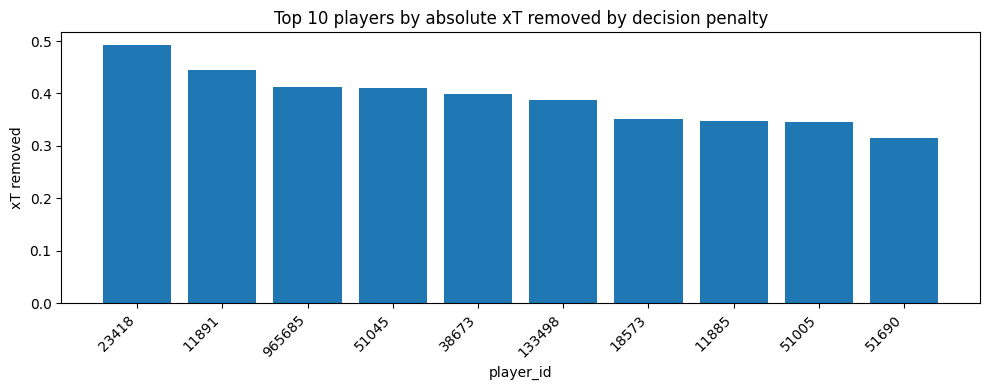

In [51]:
top_penalized = player_summary.sort_values("abs_reduction", ascending=False).head(10)

plt.figure(figsize=(10, 4))
plt.bar(top_penalized["player_id"].astype(str), top_penalized["abs_reduction"])
plt.xlabel("player_id")
plt.ylabel("xT removed")
plt.title("Top 10 players by absolute xT removed by decision penalty")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


<h1>Conclusion

This work introduces Decision-xT (D-xT), a context-aware extension of xT that incorporates decision quality into passing evaluation by comparing executed actions to available alternatives. Empirically, D-xT reduces aggregate xT by approximately 24% across matches, with consistent effects at both match and player levels. The magnitude of penalization varies substantially across players, distinguishing decision-efficient contributors from those whose xT arises from lower-quality choices. Overall, D-xT complements traditional xT by adding a decision-sensitive perspective on player contribution.


<h1>Appendix: Visualization tool to plot passing options based on D-xT (with tracking and event data)

In [28]:
def plot_passing_options(
    possession_event_id: str, events_df: pd.DataFrame, tracking_df: pd.DataFrame, *,
    event_id_col: str = "event_id", event_type_col: str = "event_type",
    possession_type_value: str = "player_possession", option_type_value: str = "passing_option",
    option_link_col: str = "associated_player_possession_event_id",
    chosen_col: str = "passing_choice", penalty_col: str = "passing_penalty_factor",
    pass_u_col: str = "pass_U", frame_end_col: str = "frame_end",
    team_id_col: str = "team_id", player_id_col: str = "player_id",
    tracking_frame_col: str = "frame", tracking_player_col: str = "player_id",
    tracking_team_col: str = "team_id", tracking_x_col: str = "x", tracking_y_col: str = "y",
    pitch_type: str = "skillcorner", pitch_length: int = 105, pitch_width: int = 68,
    figheight: float = 8,
    show_player_labels: bool = False, show_option_labels: bool = True,
):

    poss = events_df.loc[
        (events_df[event_id_col].astype(str) == str(possession_event_id)) &
        (events_df[event_type_col] == possession_type_value)
    ]
    if poss.empty:
        raise ValueError(f"No {possession_type_value} found for event_id={possession_event_id}")
    poss = poss.iloc[0]

    frame = int(poss[frame_end_col])
    ball_carrier_id, poss_team_id = poss[player_id_col], poss[team_id_col]
    penalty_factor = poss.get(penalty_col, np.nan)

    if option_link_col not in events_df.columns:
        raise ValueError(f"Missing linking column '{option_link_col}' in events_df.")

    options = events_df.loc[
        (events_df[event_type_col] == option_type_value) &
        (events_df[option_link_col].astype(str) == str(possession_event_id))
    ].copy()

    if options.empty:
        raise ValueError(f"No {option_type_value} rows linked to possession {possession_event_id}")
    if pass_u_col not in options.columns:
        raise ValueError(f"Missing '{pass_u_col}' in passing_option rows.")
    if chosen_col not in options.columns:
        raise ValueError(f"Missing '{chosen_col}' in passing_option rows.")

    chosen_idxs = options.index[options[chosen_col] == True].tolist()
    chosen_idx = chosen_idxs[0] if chosen_idxs else None

    valid_u = options[pass_u_col].astype(float)
    if valid_u.notna().sum() == 0:
        raise ValueError("All pass_U values are NaN.")
    best_idx = valid_u.idxmax()

    snap = tracking_df.loc[tracking_df[tracking_frame_col] == frame].copy()
    if snap.empty:
        raise ValueError(f"No tracking data found for frame={frame}")
    snap = snap.set_index(tracking_player_col, drop=False)

    if ball_carrier_id not in snap.index:
        raise ValueError(f"Ball carrier {ball_carrier_id} not found in tracking snapshot")

    bc = snap.loc[ball_carrier_id]
    ball_x, ball_y = float(bc[tracking_x_col]), float(bc[tracking_y_col])

    def _xy(pid):
        if pid in snap.index:
            r = snap.loc[pid]
            return float(r[tracking_x_col]), float(r[tracking_y_col])
        return np.nan, np.nan

    options["_tx"], options["_ty"] = zip(*options[player_id_col].map(_xy))

    pitch = Pitch(
        pitch_type=pitch_type, pitch_length=pitch_length, pitch_width=pitch_width,
        pitch_color="#001400", line_color="white", line_alpha=0.75, linewidth=1.5,
    )
    fig, ax = pitch.grid(figheight=figheight, endnote_height=0, title_height=0)

    in_team = snap[snap[tracking_team_col] == poss_team_id]
    out_team = snap[snap[tracking_team_col] != poss_team_id]

    ax.scatter(
        in_team[tracking_x_col], in_team[tracking_y_col],
        s=260, alpha=0.9, edgecolors="white", linewidths=1.2, zorder=2
    )
    ax.scatter(
        out_team[tracking_x_col], out_team[tracking_y_col],
        s=260, alpha=0.9, edgecolors="white", linewidths=1.2, zorder=2
    )

    if show_player_labels:
        for _, r in snap.iterrows():
            ax.text(
                float(r[tracking_x_col]), float(r[tracking_y_col]),
                str(int(r[tracking_player_col])),
                ha="center", va="center", fontsize=7, zorder=3
            )

    ax.scatter(
        [ball_x], [ball_y],
        s=420, c="#32FE6B", edgecolors="white",
        linewidths=2.8, zorder=5
    )

    penalty_is_best = pd.notna(penalty_factor) and float(penalty_factor) >= 0.999999

    for idx, r in options.iterrows():
        tx, ty = r["_tx"], r["_ty"]
        if pd.isna(tx) or pd.isna(ty):
            continue

        is_chosen, is_best = (idx == chosen_idx), (idx == best_idx)

        if penalty_is_best:
            line_color, lw = ("#32FE6B", 2.6) if is_chosen else ("white", 1.4)
        else:
            if is_best:
                line_color, lw = "#32FE6B", 2.6
            elif is_chosen:
                line_color, lw = "#E51717", 2.6
            else:
                line_color, lw = "white", 1.4

        ax.plot(
            [ball_x, tx], [ball_y, ty],
            ls="--", lw=lw, alpha=0.95, color=line_color, zorder=6
        )

        if (not penalty_is_best and (is_best or is_chosen)) or (penalty_is_best and is_chosen):
            edge, m_lw, size = line_color, 2.6, 420
        else:
            edge, m_lw, size = "white", 1.6, 320

        ax.scatter(
            [tx], [ty],
            s=size, facecolors="none",
            edgecolors=edge, linewidths=m_lw, zorder=7
        )

        if show_option_labels:
            pu = r.get(pass_u_col, np.nan)
            pu_txt = f"{pu:.3f}" if pd.notna(pu) else "NA"
            ax.text(
                tx, ty, f"{int(r[player_id_col])}\nU={pu_txt}",
                ha="center", va="center", fontsize=8, zorder=8
            )

    pf_txt = f"{float(penalty_factor):.3f}" if pd.notna(penalty_factor) else "NA"
    ax.text(
        0.5, 1.02,
        f"Possession {possession_event_id} | frame={frame} | "
        f"ball_carrier={ball_carrier_id} | penalty factor={pf_txt}",
        transform=ax.transAxes, ha="center", fontsize=12
    )

    plt.show()
    return fig, ax, options

In [48]:
import pandas as pd
import numpy as np
import requests

match_id = "1886347"
BASE_URL = "https://raw.githubusercontent.com/SkillCorner/opendata/master/data/matches"

# Match metadata (JSON)
match_url = f"{BASE_URL}/{match_id}/{match_id}_match.json"
response = requests.get(match_url)
response.raise_for_status()
match_info = response.json()

# please note that, I had to use a local file for tracking data import, because the stated method
# below in the tutorial didn't work.

# tracking_data_github_url = f"https://media.githubusercontent.com/media/SkillCorner/opendata/data/matches/{match_id}/{match_id}_tracking_extrapolated.jsonl"  # Data is stored using GitLFS
# raw_data = pd.read_json(tracking_data_github_url, lines=True)
df_tracking = pd.read_json(f"/content/{match_id}_tracking_extrapolated.jsonl", lines=True)

raw_df = pd.json_normalize(
    df_tracking.to_dict("records"),
    "player_data",
    ["frame", "timestamp", "period", "possession", "ball_data"],
)
raw_df["possession_player_id"] = raw_df["possession"].apply(lambda x: x.get("player_id"))
raw_df["possession_group"] = raw_df["possession"].apply(lambda x: x.get("group"))
raw_df[["ball_x", "ball_y", "ball_z", "is_detected_ball"]] = pd.json_normalize(raw_df["ball_data"])
raw_df = raw_df.drop(columns=["possession", "ball_data"])
raw_df["match_id"] = match_id
tracking_df = raw_df.copy()

def time_to_seconds(time_str):
    if time_str is None:
        return 90 * 60
    h, m, s = map(int, time_str.split(":"))
    return h * 3600 + m * 60 + s

raw_match_df = pd.json_normalize(match_info.copy(), max_level=2)
raw_match_df["home_team_side"] = raw_match_df["home_team_side"].astype(str)

players_df = pd.json_normalize(
    raw_match_df.to_dict("records"),
    record_path="players",
    meta=["home_team_score", "away_team_score", "date_time", "home_team_side",
          "home_team.name", "home_team.id", "away_team.name", "away_team.id"],
)

players_df = players_df[~(players_df.start_time.isna() & players_df.end_time.isna())]

players_df["total_time"] = (
    players_df["end_time"].apply(time_to_seconds) - players_df["start_time"].apply(time_to_seconds)
)

players_df["is_gk"] = players_df["player_role.acronym"] == "GK"
players_df["match_name"] = players_df["home_team.name"] + " vs " + players_df["away_team.name"]
players_df["home_away_player"] = np.where(players_df.team_id == players_df["home_team.id"], "Home", "Away")

players_df["team_name"] = np.where(
    players_df.team_id == players_df["home_team.id"], players_df["home_team.name"], players_df["away_team.name"]
)

players_df[["home_team_side_1st_half", "home_team_side_2nd_half"]] = (
    players_df["home_team_side"].astype(str).str.strip("[]").str.replace("'", "").str.split(", ", expand=True)
)

players_df["direction_player_1st_half"] = np.where(
    players_df.home_away_player == "Home", players_df.home_team_side_1st_half, players_df.home_team_side_2nd_half
)
players_df["direction_player_2nd_half"] = np.where(
    players_df.home_away_player == "Home", players_df.home_team_side_2nd_half, players_df.home_team_side_1st_half
)

players_df = players_df[
    ["start_time", "end_time", "match_name", "date_time",
     "home_team.name", "away_team.name",
     "id", "short_name", "number",
     "team_id", "team_name",
     "player_role.position_group", "total_time",
     "player_role.name", "player_role.acronym", "is_gk",
     "direction_player_1st_half", "direction_player_2nd_half"]
]

enriched_tracking_data = tracking_df.merge(players_df, left_on=["player_id"], right_on=["id"])

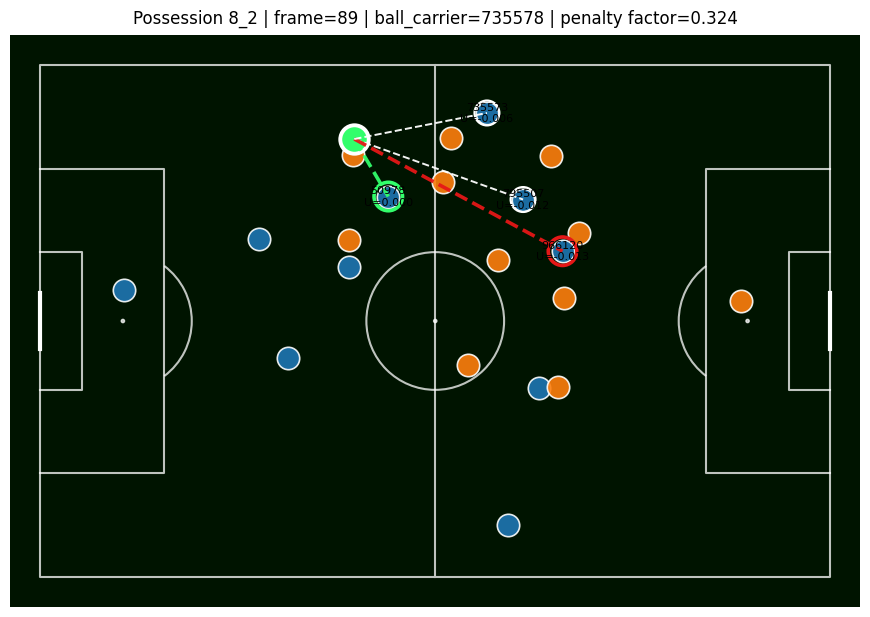

In [49]:
df_passing = pd.read_csv(f"results/{match_id}_df_passing.csv")

fig, ax, options = plot_passing_options("8_2", events_df=df_passing, tracking_df=enriched_tracking_data)

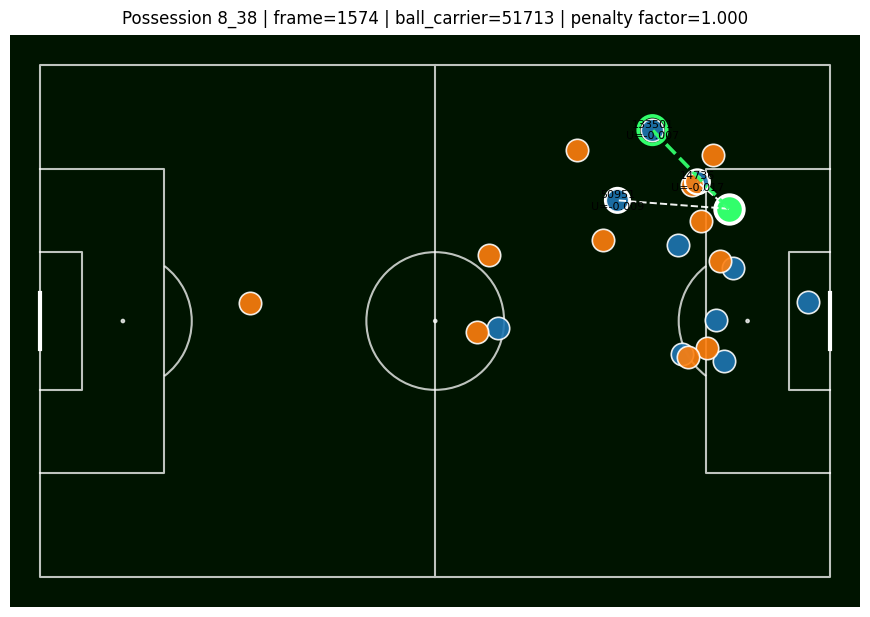

In [50]:
fig, ax, options = plot_passing_options("8_38", events_df=df_passing, tracking_df=enriched_tracking_data)

 The two panels above show passing-option contexts for two possessions. Dashed lines indicate the evaluated passing options. In the top example, the executed pass (red dashed line) is suboptimal relative to an available alternative (green dashed line), resulting in a penalty factor below 1 (0.324). In the bottom example, the executed pass coincides with the highest-utility option (green dashed line), yielding a penalty factor of 1 and no xT penalization. These examples illustrate how the framework differentiates between optimal and suboptimal decisions by explicitly comparing the chosen action to available alternatives within the same context.
